In [7]:
# -*- coding: utf-8 -*-
import gc
import numpy as np
from sklearn.linear_model import Lasso
from PIL import Image, ImageDraw


def sobel(x):
    def conv(window):  # 256x256 vs 3x3
        def mul(i, j):
            if (window[i][j]):
                return x[:, i:i + x.shape[1] - window.shape[0] + 1, j:j + x.shape[2] - window.shape[1] + 1] * window[i][
                    j]
            else:
                return np.zeros((x.shape[0], x.shape[1] - window.shape[0] + 1, x.shape[2] - window.shape[1] + 1))

        return sum([mul(i // window.shape[0], i % window.shape[0]) for i in range(9)])

    vert = conv(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    hor = conv(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))

    gradients = ((vert ** 2 + hor ** 2) ** 0.5) / 4
    gradients = gradients > 32

    del vert
    del hor
    gc.collect()
    return gradients


import math

cross_line_width = 2
cross_side_length = 15
cross_size = cross_side_length * 2 + cross_line_width


def gen_cross(size, line_width, angle, imglen, hv):
    cross = np.zeros((imglen, imglen))

    if hv == 'v':
        cross[0:size, 0:size] -= 0.1
        mid = size // 2
        sin = math.sin(angle)
        for i in range(mid):
            dy = mid - i
            dx = int(sin * dy)
            sign = 1 if dx > 0 else -1

            cross[i][mid + dx - sign] = 0
            cross[i][mid + dx] = 1.0
            cross[i][mid + dx + sign] = 1.0
            cross[i][mid + dx + 2 * sign] = 0

            cross[size - 1 - i][size - 1 - mid - dx + sign] = 0
            cross[size - 1 - i][size - 1 - mid - dx] = 1.0
            cross[size - 1 - i][size - 1 - mid - dx - sign] = 1.0
            cross[size - 1 - i][size - 1 - mid - dx - 2 * sign] = 0
        return cross

    if hv == 'h':
        subcross = gen_cross(size, line_width, angle, imglen, 'v')[0:size, 0:size].T[:, ::-1]
        cross[0:size, 0:size] = subcross
        return cross


v_crosses = [gen_cross(cross_size, cross_line_width, math.acos(-1) * i / 90, 254, 'v') for i in np.arange(85, 96, 1)]
h_crosses = [gen_cross(cross_size, cross_line_width, math.acos(-1) * i / 90, 254, 'h') for i in np.arange(85, 96, 1)]

crosses = v_crosses + h_crosses

dft2 = [np.fft.fft2(cross) for cross in crosses]

E = np.zeros([254, 254])
E[0:cross_size, 0:cross_size] = 1.0
dftE = np.fft.fft2(E)
dftE_stacked = np.tile(dftE, (1, 1, 1))
dftE_stacked = np.conjugate(dftE_stacked)
dft2_stacked = [np.conjugate(np.tile(x, (1, 1, 1))) for x in dft2]
dft2_stacked = np.stack(dft2_stacked)

yy = np.stack([(cross ** 2).sum() ** 0.5 for cross in crosses]).reshape(-1, 1, 1, 1)

dft2_stacked.shape
import matplotlib.pyplot as plt


def fft_ind(x, a, b):
    dft1 = np.tile(np.fft.fft2(x), (b - a, 1, 1, 1))
    dft1sq = np.tile(np.fft.fft2(x ** 2), (b - a, 1, 1, 1))

    xx = np.fft.ifft2(dft1sq * dftE_stacked).real ** 0.5
    xy = np.fft.ifft2(dft1 * dft2_stacked[a:b]).real

    xy = xy / xx / yy[a:b]

    xy = np.nan_to_num(xy, nan=-1.0, posinf=-1.0, neginf=-1.0)
    xy = (xy > 0) * xy

    #print(np.unravel_index(np.argmax(xy, axis=None), xy.shape))

    xx = None
    x2 = None
    gc.collect()

    return np.amax(xy, axis=0)  #[:,0:imglen-cross_size,0:imglen-cross_size]


def autocor(x):
    fft = np.fft.fft2(x)
    conv = np.fft.ifft2(fft * np.conjugate(fft))
    norm = conv[:, 0:1, 0:1]
    return (conv / norm).real


def get_points_and_lines(x, mode):
    treshold = 0.1

    sob = sobel(x)

    x_fft_v = fft_ind(sob, 0, len(v_crosses))
    x_fft_h = fft_ind(sob, len(v_crosses), len(v_crosses) + len(h_crosses))

    x_fft_v = x_fft_v > treshold  # vertical lines
    x_fft_h = x_fft_h > treshold  # horizontal lines

    x_fft = x_fft_v * x_fft_h

    x_fft_v = None
    x_fft_h = None
    sob = None
    gc.collect()

    if mode == "points":
        return x_fft.astype(bool)
    elif mode == "autocorrelation":
        return autocor(x_fft)


def predict(X, model):
    X = get_points_and_lines(X, "autocorrelation")
    X = X[:, 0:254 // 2]
    X = np.reshape(X, (len(X), -1))
    y_pred = model.predict(X)
    y = np.zeros((len(X), 8))
    y[:, 2:4] = - y_pred[:, 0:2] + y_pred[:, 4:6] + y_pred[:, 2:4]
    y[:, 4:6] = y_pred[:, 4:6] + y_pred[:, 2:4]
    y[:, 6:8] = y_pred[:, 4:6]
    y += 0.10
    return y


coefs = np.load("coefs.npy")
intercept = np.load("intercept.npy")

model = Lasso(alpha=0.0000005)
model.coef_ = coefs
model.intercept_ = intercept
np.set_printoptions(suppress=True)

C:\Users\pedan\AppData\Local\Temp/ipykernel_10572/4242871839.py:98: RuntimeWarning: invalid value encountered in sqrt
  xx = np.fft.ifft2(dft1sq * dftE_stacked).real ** 0.5
C:\Users\pedan\AppData\Local\Temp/ipykernel_10572/4242871839.py:101: RuntimeWarning: divide by zero encountered in true_divide
  xy = xy / xx / yy[a:b]


[[0.1        0.1        0.03208606 0.93896942 0.64382085 0.92784543
  0.56413376 0.09991412]
 [0.1        0.1        0.03647481 0.86008809 0.57280871 0.85970978
  0.51422746 0.10487909]
 [0.1        0.1        0.07601661 0.90704319 0.62297671 0.82610828
  0.53120254 0.06492715]
 [0.1        0.1        0.06066852 0.91156099 0.62693789 0.8744407
  0.54234959 0.08084434]
 [0.1        0.1        0.03774677 0.90110636 0.62007774 0.90049126
  0.54244313 0.09893482]]


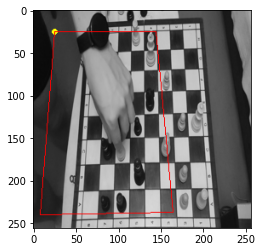

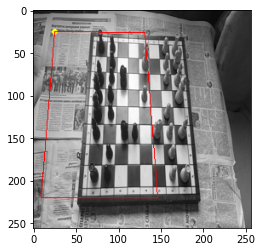

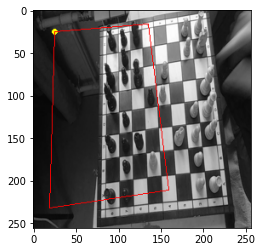

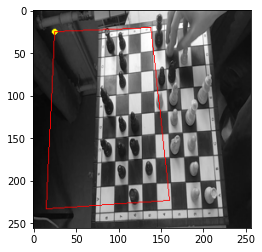

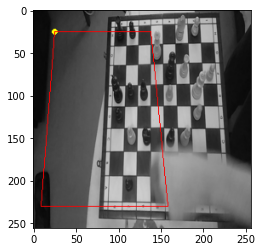

In [8]:
X = np.load("xtest.npy").reshape([-1, 256, 256]).astype(int)
y_pred = predict(X, model)
print(y_pred)

for i in range(len(X)):
    img = Image.fromarray(np.uint8(np.stack([X[i]] * 3, axis=-1)), mode='RGB')

    imglen = 256
    draw = ImageDraw.Draw(img)

    x = imglen * y_pred[i][0]
    y = imglen * y_pred[i][1]
    draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'yellow')
    x1 = imglen * y_pred[i][2]
    y1 = imglen * y_pred[i][3]
    draw.line((x, y, x1, y1), 'red')
    x2 = imglen * y_pred[i][4]
    y2 = imglen * y_pred[i][5]
    draw.line((x1, y1, x2, y2), 'red')
    x3 = imglen * y_pred[i][6]
    y3 = imglen * y_pred[i][7]
    draw.line((x2, y2, x3, y3), 'red')
    draw.line((x, y, x3, y3), 'red')

    plt.figure()
    plt.imshow(img)